In [16]:
print(">>> [PHẦN 1] Bắt đầu chạy Tiền xử lý Dữ liệu...")

import pandas as pd
import numpy as np
import kagglehub
import os
import sys
import pandas.api.types as ptypes
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Import các công cụ phân tích ---
from sklearn.preprocessing import RobustScaler # <<< DÙNG ROBUSTSCALER
from sklearn.decomposition import PCA

# --- Bỏ qua các cảnh báo (cho gọn) ---
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

>>> [PHẦN 1] Bắt đầu chạy Tiền xử lý Dữ liệu...


In [17]:
print("[Cell] Đang định nghĩa hàm _time_string_to_seconds...")

def _time_string_to_seconds(time_str):
    """Hàm nội bộ: Chuyển đổi 'HH:MM:SS' hoặc 'MM:SS' thành giây."""
    if isinstance(time_str, str):
        parts = time_str.split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2:
            m, s = map(int, parts)
            return m * 60 + s
    return pd.to_numeric(time_str, errors='coerce')

[Cell] Đang định nghĩa hàm _time_string_to_seconds...


In [18]:
print("[Cell] Đang định nghĩa hàm load_and_preprocess_data...")

def load_and_preprocess_data():
    """
    Hàm chính: Tải, làm sạch, và chuẩn bị dữ liệu (từ code của bạn).
    Sẽ trả về DataFrame đã làm sạch (chưa scale).
    """
    print("\n" + "="*50)
    print("--- Bắt đầu Giai đoạn 1: Tiền xử lý Dữ liệu (Hồi quy) ---")
    
    try:
        CURRENT_DIR = os.getcwd() 
        ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
        
        RAW_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'raw')
        # Sửa KAGGLE_DATASET để khớp với code của đồng đội
        KAGGLE_DATASET = "kristhecoder/youtube-revenue-data-20182021" 
        CSV_FILES_TO_LOAD = ['Table-data-2018.csv', 'Table-data-2019.csv', 'Table-data-2020.csv']
        
        print(f"Thư mục gốc của dự án: {ROOT_DIR}")
    except Exception as e:
        print(f"Lỗi khi thiết lập đường dẫn: {e}")
        return None
    
    # --- B. Tải và Gộp (Concat) 3 file CSV ---
    files_to_load = CSV_FILES_TO_LOAD
    df_list = []
    data_folder = RAW_DATA_PATH
    
    print("\nĐang tìm dữ liệu cục bộ...")
    for f_name in files_to_load:
        file_path = os.path.join(data_folder, f_name)
        if os.path.exists(file_path):
            try:
                df_list.append(pd.read_csv(file_path)[1:-1])
                print(f"Đã tải file: {f_name}")
            except Exception as read_e:
                print(f"LỖI: Không thể đọc file {f_name}. {read_e}")
        else:
             print(f"Cảnh báo: Không tìm thấy file {f_name} tại {file_path}")

    # Kịch bản 3: Tải từ Kaggle (nếu không có file nào)
    if not df_list:
        print("Không tìm thấy file cục bộ. Đang thử tải từ Kaggle...")
        try:
            # Dùng kagglehub.dataset_download như code đồng đội
            data_folder_download = kagglehub.dataset_download(KAGGLE_DATASET, path=RAW_DATA_PATH)
            print(f"Tải từ Kaggle thành công vào: {data_folder_download}")
            # Chạy lại logic đọc file
            for f_name in CSV_FILES_TO_LOAD:
                file_path = os.path.join(data_folder_download, f_name)
                if os.path.exists(file_path):
                    df_list.append(pd.read_csv(file_path)[1:-1])
                    print(f"Đã tải file: {f_name}")
        except Exception as e:
            print(f"LỖI: Tải từ Kaggle cũng thất bại. {e}")
            return None

    if not df_list:
        print("LỖI: Không đọc được file CSV nào. Dừng chương trình.")
        return None
        
    df = pd.concat(df_list).reset_index(drop=True)
    print("Tải và gộp file thành công.")

    # --- C. Sửa tên cột (Từ code của bạn) ---
    df.columns = df.columns.str.replace(' ', '_')
    col_map = {
        'Av­er­age_views_per_view­er': 'Average_views_per_viewer',
        'Unique_view­ers': 'Unique_viewers',
        'Av­er­age_per­cent­age_viewed_(%)': 'Average_viewed_(%)',
        'Im­pres­sions': 'Impressions', 'Dis\xadlikes': 'Dislikes',
        'Sub­scribers_lost': 'Subscribers_lost', 'Sub­scribers_gained': 'Subscribers_gained',
        'Videos_pub­lished': 'Videos_published_original', # Giữ tên gốc của bạn
        'Videos_ad­ded': 'Videos_added_original', # Giữ tên gốc của bạn
        'Sub­scribers': 'Subscribers_net_change',
        'Im­pres­sions_click-through_rate_(%)': 'Click_rate_(%)',
        'Com­ments_ad­ded': 'Comments', 'Watch_time_(hours)': 'Watch_hours',
        'Av­er­age_view_dur­a­tion': 'Average_view_sec',
        'Your_es­tim­ated_rev­en­ue_(USD)': 'Revenue_(USD)',
        'Likes_(vs._dis­likes)_(%)': 'Likes_vs_Dislikes_(%)',
    }
    # Sửa tên cột đồng đội (Nếu có)
    col_map_teammate = {
        'Videos_pub­lished':'Videos_added', # Tên của đồng đội
        'Videos_ad­ded':'Videos_published', # Tên của đồng đội
    }
    df = df.rename(columns=col_map_teammate)
    df = df.rename(columns=col_map) # Chạy col_map của bạn sau
    
    # --- D. Xử lý NaN (Từ code của bạn) ---
    # Đồng đội của bạn fill 'Videos_published'
    if 'Videos_published' in df.columns:
         df['Videos_published'] = df['Videos_published'].fillna(0)
    # Bạn fill cả 2 (An toàn hơn)
    if 'Videos_added_original' in df.columns:
        df['Videos_added_original'] = df['Videos_added_original'].fillna(0)
    if 'Videos_published_original' in df.columns:
        df['Videos_published_original'] = df['Videos_published_original'].fillna(0)


    # --- E. Chuyển đổi kiểu dữ liệu (Từ code của bạn) ---
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    if 'Average_view_sec' in df.columns and ptypes.is_object_dtype(df['Average_view_sec']):
        print("Phát hiện 'Average_view_sec' là string. Đang chuyển đổi sang giây...")
        df['Average_view_sec'] = df['Average_view_sec'].apply(_time_string_to_seconds)
    
    numeric_cols = df.select_dtypes(include='object').columns.drop('Date', errors='ignore')
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(0) 

    # --- F. Xử lý giá trị âm (Từ code của bạn) ---
    print("Đang xử lý giá trị âm...")
    cols_to_clip = ['Likes', 'Dislikes', 'Views', 'Impressions', 'Comments', 'Shares', 
                    'Watch_hours', 'Unique_viewers', 'Average_view_sec', 'Revenue_(USD)']
    for col in cols_to_clip:
        if col in df.columns: 
            df[col] = df[col].clip(lower=0) 

    # --- G. Kỹ thuật thuộc tính (Từ code của bạn) ---
    if 'Subscribers_net_change' in df.columns:
        df['Subs_accumulated'] = df['Subscribers_net_change'].cumsum()
    elif 'Subs_accumulated' not in df.columns:
         df['Subs_accumulated'] = 0 

    # --- H. Lựa chọn thuộc tính cuối cùng (Từ code của bạn) ---
    print("Đang lựa chọn thuộc tính cuối cùng...")
    features_to_drop = [
        'Date', # Bỏ Date vì PCA không xử lý được
        'Subscribers_net_change', 
        'Likes_vs_Dislikes_(%)', 
        'Videos_added_original', 
        'Videos_published_original',
        # Các cột đồng đội bạn đã bỏ:
        'Subscribers_lost',
        'Subscribers_gained'
    ]
    
    cols_to_keep = [col for col in df.columns if col not in features_to_drop and col in df.columns]
    df_clean = df[cols_to_keep]
    
    print(f"Tiền xử lý hoàn tất. Dữ liệu sạch có {df_clean.shape[0]} hàng và {df_clean.shape[1]} cột.")
    print("--- Kết thúc Giai đoạn 1 ---")
    return df_clean

[Cell] Đang định nghĩa hàm load_and_preprocess_data...


In [19]:
df = load_and_preprocess_data()
print("\n>>> [PHẦN 1] Đã chạy xong.")


--- Bắt đầu Giai đoạn 1: Tiền xử lý Dữ liệu (Hồi quy) ---
Thư mục gốc của dự án: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau

Đang tìm dữ liệu cục bộ...
Đã tải file: Table-data-2018.csv
Đã tải file: Table-data-2019.csv
Đã tải file: Table-data-2020.csv
Tải và gộp file thành công.
Phát hiện 'Average_view_sec' là string. Đang chuyển đổi sang giây...
Đang xử lý giá trị âm...
Đang lựa chọn thuộc tính cuối cùng...
Tiền xử lý hoàn tất. Dữ liệu sạch có 1132 hàng và 16 cột.
--- Kết thúc Giai đoạn 1 ---

>>> [PHẦN 1] Đã chạy xong.


In [20]:
if df is not None:
    # Phân tách X và y
    target = 'Revenue_(USD)'
    X = df.drop(columns=[target])
    y = df[target]

    print("Kích thước dữ liệu:", df.shape)
    print("\n🔹 Thông tin dữ liệu:")
    print(df.info())
else:
    print("LỖI: DataFrame 'df' rỗng, không thể tiếp tục phân tích.")


Kích thước dữ liệu: (1132, 16)

🔹 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Average_views_per_viewer  1132 non-null   float64
 1   Unique_viewers            1132 non-null   float64
 2   Click_rate_(%)            1132 non-null   float64
 3   Impressions               1132 non-null   float64
 4   Comments                  1132 non-null   float64
 5   Shares                    1132 non-null   float64
 6   Dislikes                  1132 non-null   float64
 7   Likes                     1132 non-null   float64
 8   Average_viewed_(%)        1132 non-null   float64
 9   Videos_added              1132 non-null   float64
 10  Videos_published          1132 non-null   float64
 11  Views                     1132 non-null   float64
 12  Watch_hours               1132 non-null   float64
 13  Average_vi

In [21]:
if df is not None:
    print("🔹 Thống kê mô tả từng cột:")
    display(df.describe().T.round(5))


🔹 Thống kê mô tả từng cột:


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1132.0,1.62723,3.258400e-01,1.0000,1.42695,1.55675,1.79115,2.615800e+00
Unique_viewers,1132.0,25396.72615,5.491041e+04,8.0000,457.50000,4115.00000,18102.50000,4.822540e+05
Click_rate_(%),1132.0,6.56864,2.246660e+00,3.5200,5.16750,6.11000,7.12250,2.314000e+01
Impressions,1132.0,833559.09452,1.878691e+06,44.0000,8469.00000,68862.00000,398580.75000,1.632350e+07
Comments,1132.0,224.11926,7.370135e+02,0.0000,2.00000,28.00000,128.25000,1.158200e+04
Shares,1132.0,123.03622,3.339799e+02,0.0000,2.00000,22.00000,87.00000,6.513000e+03
Dislikes,1132.0,39.39488,8.149386e+01,0.0000,0.75000,6.00000,31.00000,6.640000e+02
Likes,1132.0,2788.84011,7.468639e+03,0.0000,15.00000,257.50000,1246.25000,6.354300e+04
Average_viewed_(%),1132.0,28.77736,6.136640e+00,10.9500,24.22750,28.09500,32.55000,6.219000e+01
Videos_added,1132.0,0.11042,3.246400e-01,0.0000,0.00000,0.00000,0.00000,3.000000e+00


In [22]:
if df is not None:
    print("\n🔹 Phân tích độ lệch và độ nhọn:")
    stats_df = pd.DataFrame({
        'Mean': df.mean(),
        'Std': df.std(),
        'Skewness': df.skew(),
        'Kurtosis': df.kurt()
    }).round(3)
    display(stats_df)
    print(">>> KẾT LUẬN: Skewness và Kurtosis rất cao -> Dữ liệu lệch và có ngoại lai.")


🔹 Phân tích độ lệch và độ nhọn:


,Mean,Std,Skewness,Kurtosis
Average_views_per_viewer,1.627,0.326,0.783,0.427
Unique_viewers,25396.726,54910.406,3.740,17.174
Click_rate_(%),6.569,2.247,2.342,8.981
Impressions,833559.095,1878690.903,3.197,12.204
Comments,224.119,737.014,7.827,81.921
Shares,123.036,333.980,8.726,130.222
Dislikes,39.395,81.494,3.346,13.745
Likes,2788.840,7468.639,4.880,28.681
Average_viewed_(%),28.777,6.137,0.816,1.581
Videos_added,0.110,0.325,2.951,9.617


>>> KẾT LUẬN: Skewness và Kurtosis rất cao -> Dữ liệu lệch và có ngoại lai.



🔹 Trực quan hóa phân phối (Histogram):


<Figure size 1200x800 with 0 Axes>

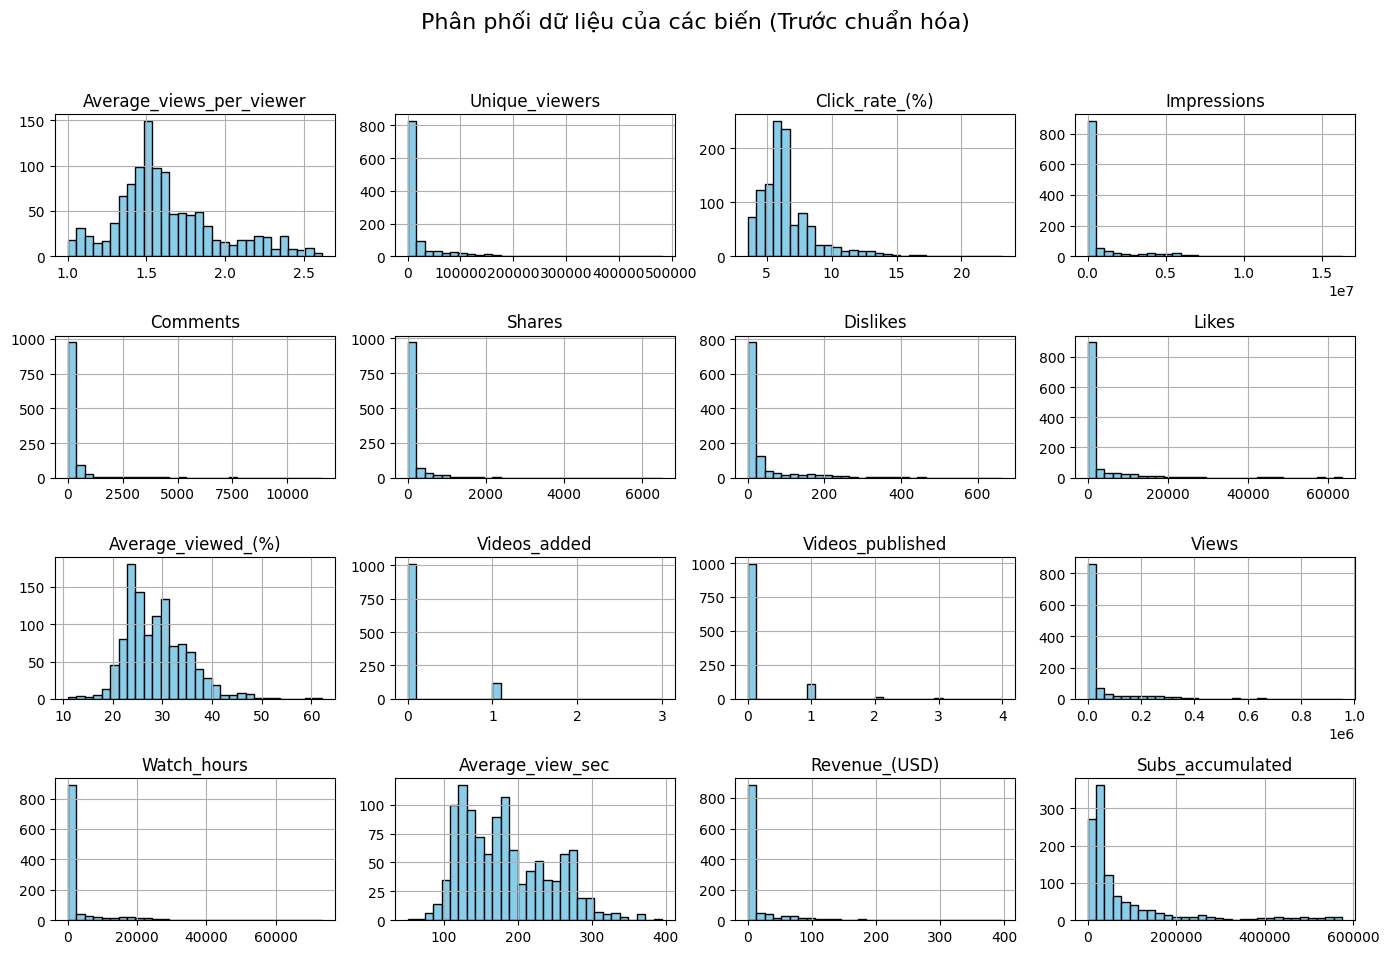

In [23]:
if df is not None:
    print("\n🔹 Trực quan hóa phân phối (Histogram):")
    plt.figure(figsize=(12,8))
    df.hist(bins=30, figsize=(14,10), color='skyblue', edgecolor='black')
    plt.suptitle("Phân phối dữ liệu của các biến (Trước chuẩn hóa)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



🔹 Trực quan hóa ngoại lai (Boxplot):


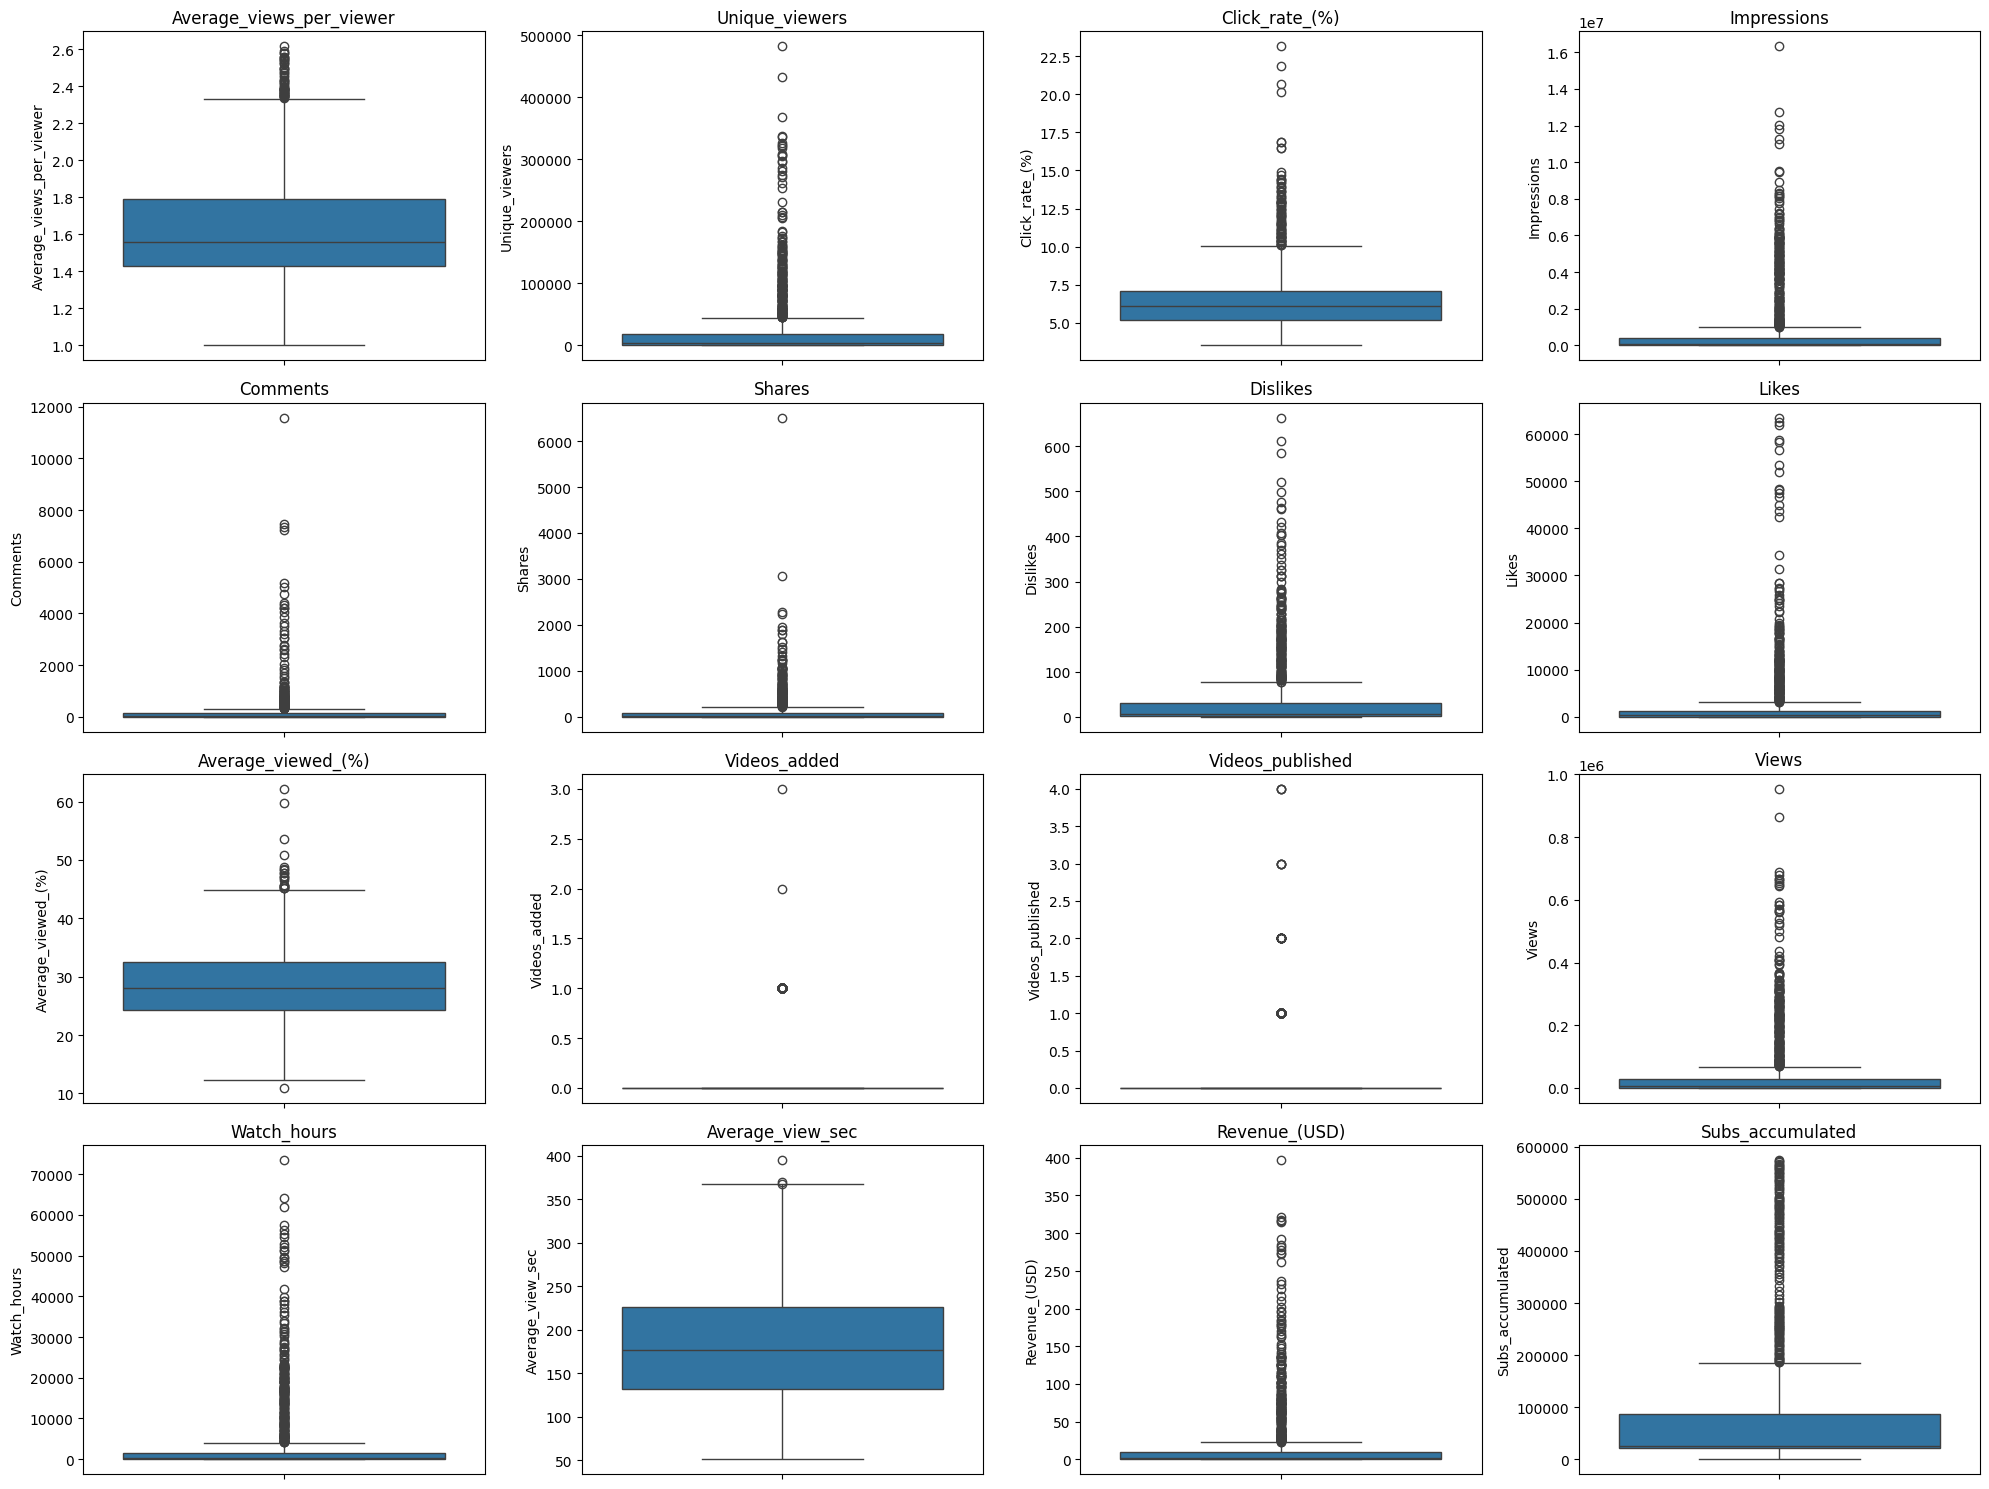

>>> KẾT LUẬN: Các biểu đồ hộp bị 'nén' -> Khẳng định có ngoại lai CỰC LỚN.


In [24]:
if df is not None:
    print("\n🔹 Trực quan hóa ngoại lai (Boxplot):")
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    plt.figure(figsize=(20, 15))
    num_cols = len(numerical_cols)
    cols_per_row = 4
    num_rows = (num_cols + cols_per_row - 1) // cols_per_row 

    for i, col in enumerate(numerical_cols):
        plt.subplot(num_rows, cols_per_row, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()
    print(">>> KẾT LUẬN: Các biểu đồ hộp bị 'nén' -> Khẳng định có ngoại lai CỰC LỚN.")


🔹 Ma trận tương quan (Heatmap):


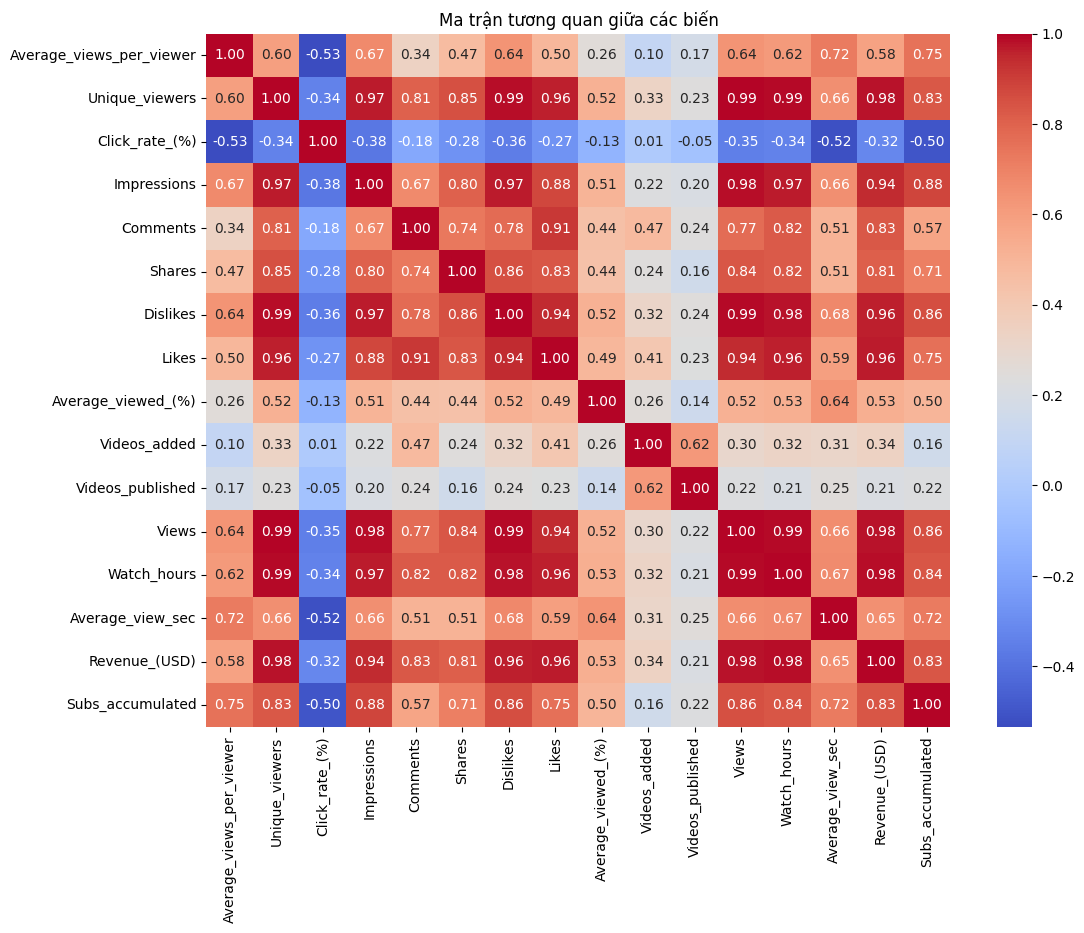

>>> KẾT LUẬN: Đa cộng tuyến cao (ví dụ: Views, Watch_hours, Impressions).


In [25]:
if df is not None:
    print("\n🔹 Ma trận tương quan (Heatmap):")
    plt.figure(figsize=(12,9))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Ma trận tương quan giữa các biến")
    plt.show()
    print(">>> KẾT LUẬN: Đa cộng tuyến cao (ví dụ: Views, Watch_hours, Impressions).")

In [26]:
if df is not None:
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    print("\n🔹 Dữ liệu sau khi chuẩn hóa (RobustScaler):")
    display(X_scaled_df.describe().T.round(5))
else:
    print("LỖI: 'df' rỗng.")


🔹 Dữ liệu sau khi chuẩn hóa (RobustScaler):


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1132.0,0.19353,0.89468,-1.52869,-0.35640,-0.0,0.64360,2.90788
Unique_viewers,1132.0,1.20611,3.11195,-0.23276,-0.20728,0.0,0.79272,27.09770
Click_rate_(%),1132.0,0.23460,1.14918,-1.32481,-0.48210,0.0,0.51790,8.71100
Impressions,1132.0,1.96020,4.81578,-0.17641,-0.15481,0.0,0.84519,41.66662
Comments,1132.0,1.55342,5.83773,-0.22178,-0.20594,0.0,0.79406,91.51683
Shares,1132.0,1.18866,3.92917,-0.25882,-0.23529,0.0,0.76471,76.36471
Dislikes,1132.0,1.10396,2.69401,-0.19835,-0.17355,0.0,0.82645,21.75207
Likes,1132.0,2.05591,6.06590,-0.20914,-0.19695,0.0,0.80305,51.39939
Average_viewed_(%),1132.0,0.08199,0.73736,-2.06008,-0.46470,0.0,0.53530,4.09673
Videos_added,1132.0,0.11042,0.32464,0.00000,0.00000,0.0,0.00000,3.00000


In [27]:
if df is not None:
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled) # Chạy PCA trên dữ liệu đã RobustScale

    # Tạo DataFrame PCA
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    print("\n🔹 Thống kê các Thành phần chính (Kịch bản Robust):")
    display(X_pca_df.describe().T.round(5))
else:
    print("LỖI: 'df' rỗng.")


🔹 Thống kê các Thành phần chính (Kịch bản Robust):


,count,mean,std,min,25%,50%,75%,max
PC1,1132.0,0.0,12.79271,-5.65096,-5.35550,-4.74936,-2.43799,102.11097
PC2,1132.0,-0.0,3.56557,-19.87875,0.23474,0.54993,0.64777,54.72221
PC3,1132.0,-0.0,2.04317,-9.92573,-0.00630,0.04283,0.11721,51.05108
PC4,1132.0,0.0,1.26118,-9.83268,-0.72844,-0.08477,0.49135,7.80305
PC5,1132.0,-0.0,0.92876,-12.71292,-0.23409,0.18317,0.34206,12.59432
PC6,1132.0,-0.0,0.78361,-6.83654,-0.36269,-0.09647,0.21813,5.53201
PC7,1132.0,0.0,0.65337,-2.98598,-0.40478,-0.08539,0.40316,3.75330
PC8,1132.0,-0.0,0.56653,-2.23706,-0.41268,-0.01845,0.33617,2.39340
PC9,1132.0,-0.0,0.52992,-4.00373,-0.23280,-0.02505,0.12138,5.86588
PC10,1132.0,-0.0,0.38488,-3.22744,-0.08740,0.00745,0.13228,2.35971



🔹 Phương sai giải thích (Kịch bản Robust):
PC1: 88.44% | Tổng tích lũy: 88.44%
PC2: 6.87% | Tổng tích lũy: 95.31%
PC3: 2.26% | Tổng tích lũy: 97.56%
PC4: 0.86% | Tổng tích lũy: 98.42%
PC5: 0.47% | Tổng tích lũy: 98.89%
PC6: 0.33% | Tổng tích lũy: 99.22%
PC7: 0.23% | Tổng tích lũy: 99.45%
PC8: 0.17% | Tổng tích lũy: 99.62%
PC9: 0.15% | Tổng tích lũy: 99.77%
PC10: 0.08% | Tổng tích lũy: 99.85%
PC11: 0.05% | Tổng tích lũy: 99.91%
PC12: 0.04% | Tổng tích lũy: 99.95%
PC13: 0.02% | Tổng tích lũy: 99.98%
PC14: 0.02% | Tổng tích lũy: 99.99%
PC15: 0.01% | Tổng tích lũy: 100.00%


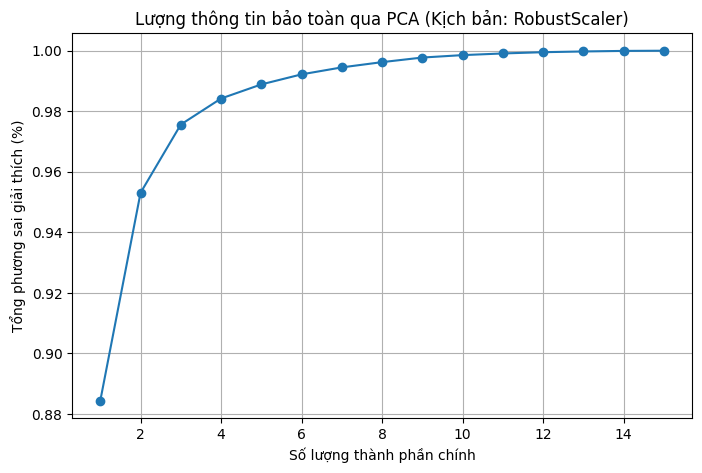

In [28]:
if df is not None:
    print("\n🔹 Phương sai giải thích (Kịch bản Robust):")
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)

    for i, var in enumerate(explained_var_ratio):
        print(f"PC{i+1}: {var*100:.2f}% | Tổng tích lũy: {cumulative_var[i]*100:.2f}%")

    # Biểu đồ trực quan
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
    plt.xlabel('Số lượng thành phần chính')
    plt.ylabel('Tổng phương sai giải thích (%)')
    plt.title('Lượng thông tin bảo toàn qua PCA (Kịch bản: RobustScaler)')
    plt.grid(True)
    plt.show()
else:
    print("LỖI: 'df' rỗng.")


🔹 Trực quan hóa PC theo cặp (Kịch bản Robust)


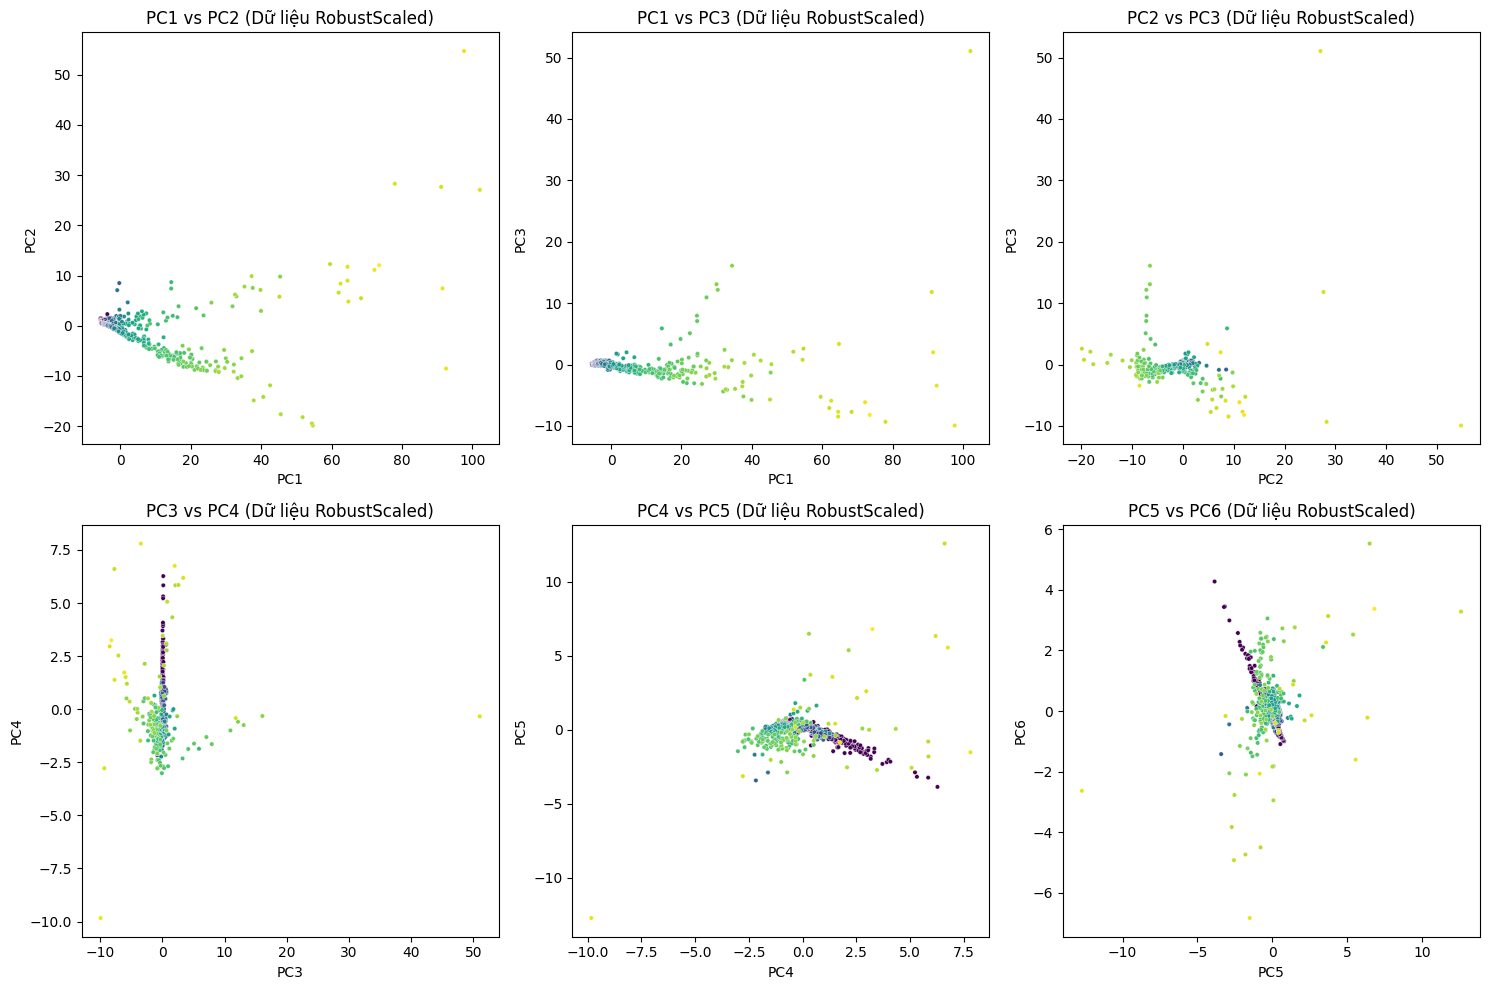

In [29]:
if df is not None:
    print("\n🔹 Trực quan hóa PC theo cặp (Kịch bản Robust)")
    pca_n = PCA(n_components=6)
    X_pca_n = pca_n.fit_transform(X_scaled)

    # <<< SỬA LỖI: DÙNG LOG1P CHO MÀU SẮC (HUE) >>>
    # Biến y (Revenue) bị lệch nặng, dùng y_gốc làm màu sẽ cho toàn màu tím.
    # Dùng log1p(y) "nén" thang màu lại giúp biểu đồ có dải màu (gradient) đẹp.
    y_color = np.log1p(y) 

    plt.figure(figsize=(15,10))
    pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

    for i, (a,b) in enumerate(pairs[:6]):
        plt.subplot(2,3,i+1)
        sns.scatterplot(x=X_pca_n[:,a], y=X_pca_n[:,b], hue=y_color, palette='viridis', legend=False, s=10) # s=10 cho điểm nhỏ hơn
        plt.xlabel(f'PC{a+1}')
        plt.ylabel(f'PC{b+1}')
        plt.title(f'PC{a+1} vs PC{b+1} (Dữ liệu RobustScaled)')
    plt.tight_layout()
    plt.show()
else:
    print("LỖI: 'df' rỗng.")


🔹 Tương quan PC (Kịch bản Robust) với Doanh thu:


Revenue_(USD)    1.000000
PC1              0.981022
PC6              0.032551
PC5              0.020208
PC4              0.017275
PC2             -0.066329
PC3             -0.081910
Name: Revenue_(USD), dtype: float64

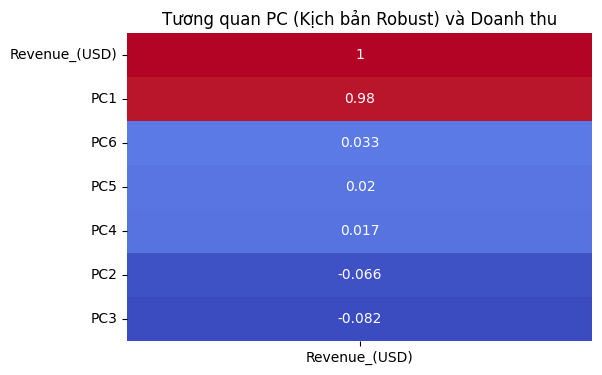

In [30]:
if df is not None:
    print("\n🔹 Tương quan PC (Kịch bản Robust) với Doanh thu:")
    pca_df = pd.DataFrame(X_pca_n, columns=[f'PC{i+1}' for i in range(6)])
    pca_df[target] = y.values # y gốc (chưa log)

    corr = pca_df.corr()[target].sort_values(ascending=False)
    display(corr)

    # Biểu đồ heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', cbar=False)
    plt.title('Tương quan PC (Kịch bản Robust) và Doanh thu')
    plt.show()
else:
    print("LỖI: 'df' rỗng.")